In [1]:
import matplotlib.pyplot as plt
import numpy as np
import timeautoencoder as tae
import timediffusion as tdf
import DP_Sliding as dp
import pandas as pd
import torch
import os
import time 
import process_edited as pce
import random
from torch.utils.data import random_split
import CSDI
import cond as cd

# ETTh-small : https://github.com/zhouhaoyi/ETDataset/tree/main
time_duration = []

data = 'C:/Users/namjo/OneDrive/Desktop/TimeAutoDiff/Dataset/nasdaq100_2019'
filename = f'{data}.csv'

### Read dataframe
print(filename)
real_df = pd.read_csv(filename)
real_df = real_df[['Symbol','Open','date']]
##############################################################################################################################
### Pre-processing Data
threshold = 1; device = 'cuda'; column_to_partition = 'Symbol'
response_train, cond_train, time_info_train = dp.multi_split_train_test(real_df, column_to_partition)


C:/Users/namjo/OneDrive/Desktop/TimeAutoDiff/Dataset/nasdaq100_2019.csv


In [2]:
# Put the variables you want to generate on response list, the remaining variables will be 
response_list = ['Open']; VAE_training = 2500; diff_training = 5000;
response_train, cond_train, time_info_train = dp.multi_split_train_test(real_df,'Symbol')
response_df = real_df[response_list]; real_df1 = real_df.drop('date', axis=1); cond_df = real_df1.drop(response_list, axis=1)
model = cd.C_TimeAutoDiff(response_df, cond_df, response_train, cond_train.unsqueeze(2), time_info_train, VAE_training, diff_training)

Output()

Output()

In [6]:
device = 'cuda'; diffusion_steps = 100; Batch_size, Seq_len, _ = response_train.shape; 
_synth_data = cd.cond_sampling(response_df, model[0], model[1], cond_train.unsqueeze(2), time_info_train, Batch_size, Seq_len, Lat_dim = 5)

In [28]:
label = 99

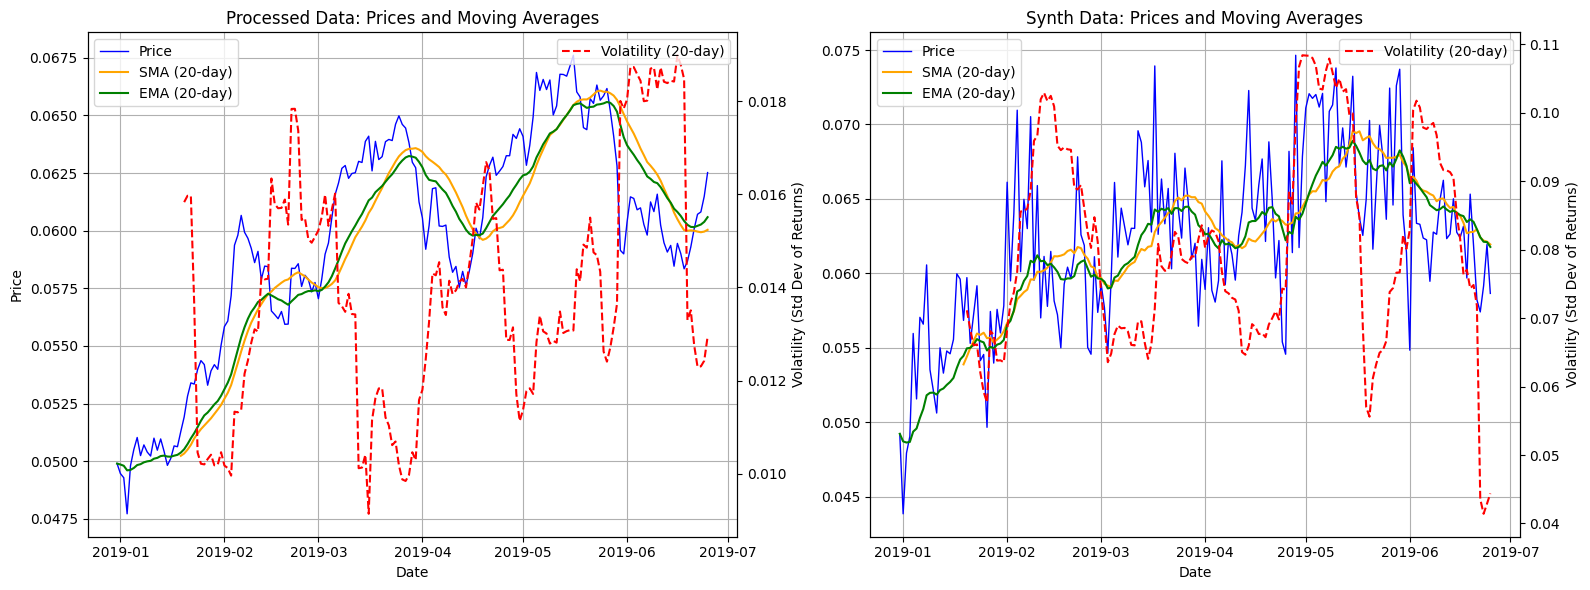

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Simulated processed_data and _synth_data
np.random.seed(42)
# Create date range
dates = pd.date_range(start="2018-12-31", periods=177)

# Example data
processed_prices = response_train[label,:,0].numpy()  # Replace with processed_data
synth_prices = _synth_data[label,:,0].cpu().numpy()      # Replace with _synth_data

# Create DataFrames for processed_data and _synth_data
processed_df = pd.DataFrame({"Date": dates, "Price": processed_prices})
processed_df.set_index("Date", inplace=True)
synth_df = pd.DataFrame({"Date": dates, "Price": synth_prices})
synth_df.set_index("Date", inplace=True)

# Function to calculate additional columns (returns, volatility, moving averages)
def process_data(df):
    df["Return"] = df["Price"].pct_change()
    df["Volatility"] = df["Return"].rolling(window=20).std()
    df["SMA_20"] = df["Price"].rolling(window=20).mean()
    df["EMA_20"] = df["Price"].ewm(span=20, adjust=False).mean()
    return df

processed_df = process_data(processed_df)
synth_df = process_data(synth_df)

# Plotting both datasets side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=False)

# Plot for processed_data
ax1 = axes[0]
ax1.plot(processed_df.index, processed_df["Price"], label="Price", color="blue", linewidth=1)
ax1.plot(processed_df.index, processed_df["SMA_20"], label="SMA (20-day)", color="orange", linewidth=1.5)
ax1.plot(processed_df.index, processed_df["EMA_20"], label="EMA (20-day)", color="green", linewidth=1.5)
ax1.set_title("Processed Data: Prices and Moving Averages")
ax1.set_xlabel("Date")
ax1.set_ylabel("Price")
ax1.legend(loc="upper left")
ax1.grid()

ax1_vol = ax1.twinx()
ax1_vol.plot(processed_df.index, processed_df["Volatility"], label="Volatility (20-day)", color="red", linestyle="--", linewidth=1.5)
ax1_vol.set_ylabel("Volatility (Std Dev of Returns)")
ax1_vol.legend(loc="upper right")

# Plot for _synth_data
ax2 = axes[1]
ax2.plot(synth_df.index, synth_df["Price"], label="Price", color="blue", linewidth=1)
ax2.plot(synth_df.index, synth_df["SMA_20"], label="SMA (20-day)", color="orange", linewidth=1.5)
ax2.plot(synth_df.index, synth_df["EMA_20"], label="EMA (20-day)", color="green", linewidth=1.5)
ax2.set_title("Synth Data: Prices and Moving Averages")
ax2.set_xlabel("Date")
ax2.legend(loc="upper left")
ax2.grid()

ax2_vol = ax2.twinx()
ax2_vol.plot(synth_df.index, synth_df["Volatility"], label="Volatility (20-day)", color="red", linestyle="--", linewidth=1.5)
ax2_vol.set_ylabel("Volatility (Std Dev of Returns)")
ax2_vol.legend(loc="upper right")

plt.tight_layout()
plt.show()
